# Imports and Setup

In [1]:
import numpy as np

import healpy as hp
from healpy.newvisufunc import projview

from astrotools import healpytools as hpt

from matplotlib import pyplot as plt, ticker as mticker
import matplotlib.colors as colors

import copy

import os
import sys

In [2]:
#The module that needs to be tested

#Necessary for relative imports (see https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im)
module_path = os.path.abspath(os.path.join('../../'))           # '../../' is needed because the parent directory is two directories upstream of this test directory
if module_path not in sys.path:
    sys.path.append(module_path)

from kNN_ASMR import HelperFunctions as hf
from kNN_ASMR import kNN_2D_Ang

In [3]:
# from kNN_ASMR.DataSets.kNN_2D_Ang import faong

In [4]:
plt.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 18})
plt.rcParams["axes.linewidth"] = 2*0.8
plt.rcParams["xtick.major.width"] = 2*0.8
plt.rcParams["ytick.major.width"] = 2*0.8
plt.rcParams["xtick.major.size"] = 1.5*3.5
plt.rcParams["ytick.major.size"] = 1.5*3.5
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["xtick.minor.width"] = 2*0.6
plt.rcParams["ytick.minor.width"] = 2*0.6
plt.rcParams["xtick.minor.size"] = 1.5*2
plt.rcParams["ytick.minor.size"] = 1.5*2
prop_cycle = plt.rcParams['axes.prop_cycle']
DefaultColorCycle = prop_cycle.by_key()['color']
BrightColors = ['cyan', 'yellow', 'lime', '#E0B0FF']

# Function Definitions

In [5]:
def cat2hpx(lon, lat, nside, radec=True):
    '''
    Convert a catalogue to a HEALPix map of number counts per resolution
    element.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon, glat

    nside : int
        HEALPix nside of the target map

    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.

    Returns
    -------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates
    '''

    npix = hp.nside2npix(nside)

    if radec:
        eq = SkyCoord(lon, lat, frame='icrs', unit='deg')
        l, b = eq.galactic.l.value, eq.galactic.b.value
    else:
        l, b = lon, lat

    # conver to theta, phi
    theta = np.radians(90. - b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts

    return hpx_map

In [6]:
def PoissonUniformCDFs(a, n, kNN):

    mean=n*a
    sum=0
    for i in range(kNN):
        sum+=(mean**i/np.math.factorial(i))*np.exp(-1*mean)

    return 1-sum

# Main

## Generating and saving datasets

In [5]:
fol_save = '/home/kaustubh/Projects/kNN-Samrajya/Datasets/kNN_2D_Ang'

### Continuous field, unmasked

In [6]:
NSIDE = 512
fol = f'/media/kaustubh/Windows/Downloads_data/Thesis_spare_data/Forecasts/Galaxy_density_fields/LSST_y1/Downgraded_maps/NSIDE_{NSIDE}'

delta_gal = hp.read_map(f'{fol}/downgraded_density_combined_bins.npy')
mask = np.ones_like(delta_gal)
mask[mask!=1] = hp.UNSEEN
delta_gal_masked = copy.deepcopy(delta_gal)
delta_gal_masked[mask!=1]=hp.UNSEEN

delta_gal_sampling = copy.deepcopy(delta_gal)

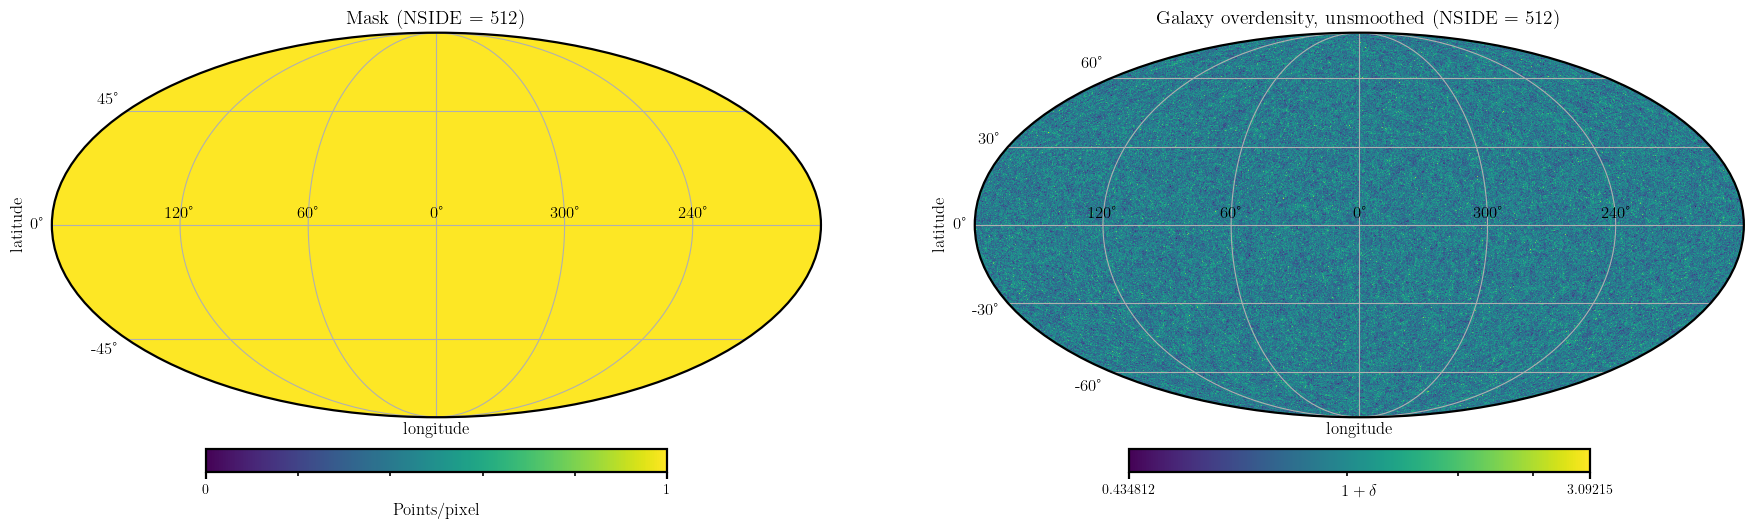

In [9]:
fig = plt.figure(figsize=(18, 7))
ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)

plt.axes(ax1)
projview(
    mask,
    coord=["C"],
    graticule=True,
    graticule_labels=True,
    unit="\nPoints/pixel",
    xlabel="longitude",
    ylabel="latitude",
    cbar=True,
    cb_orientation="horizontal",
    latitude_grid_spacing=45,
    projection_type="mollweide",
    title=f"Mask (NSIDE = {NSIDE})",
    norm="linear", 
    flip="astro",
    min=0,
    max=1,
    hold=True,
    sub=121
)

plt.axes(ax2)
projview(
    1.+delta_gal_masked,
    coord=["C"],
    graticule=True,
    graticule_labels=True,
    unit=r'$1+\delta$',
    xlabel="longitude",
    ylabel="latitude",
    cbar=True,
    cb_orientation="horizontal",
    latitude_grid_spacing=30,
    projection_type="mollweide",
    title=f"Galaxy overdensity, unsmoothed (NSIDE = {NSIDE})",
    norm="log", 
    flip="astro",
    min=1+delta_gal_masked[(delta_gal_masked!=hp.UNSEEN)&(delta_gal_masked!=-1)].min(),
    max=1+delta_gal_masked[delta_gal_masked!=hp.UNSEEN].max(),
    hold=True,
    sub=122
)

plt.show()
plt.close()

In [7]:
#Saving

np.save(f'{fol_save}/LSST_y1_forecast_Agora_lightcone_galaxy_overdensity_field_NSIDE_{NSIDE}_unmasked.npy', delta_gal_masked)

### Discrete tracers

In [8]:
N_realisations = int(1e1)
N_obj = int(2.8e4)
Nobj = int(N_obj*12*NSIDE**2/len(np.where(mask==1)[0]))

r1_pos_arr = np.zeros((N_realisations, Nobj, 2))
r1_pos_masked_ds_arr = np.zeros((N_realisations, N_obj, 2))

#Randoms
for i, r1_pos in enumerate(r1_pos_arr):

    r1_pos[:, 0] = np.arcsin(np.random.uniform(low=-1, high=1, size=r1_pos.shape[0]))
    r1_pos[:, 1] = np.random.uniform(low=0, high=2*np.pi, size=r1_pos.shape[0])
    ipix = hp.ang2pix(NSIDE, np.rad2deg(r1_pos[:, 1]), np.rad2deg(r1_pos[:, 0]), nest=False, lonlat=True)
    mask_val = mask[ipix]
    ind_masked = np.where(mask_val!=hp.UNSEEN)[0]
    r1_pos_masked = r1_pos[ind_masked]
    r1_pos_masked_ds_arr[i] = r1_pos_masked[np.random.choice(len(r1_pos_masked), N_obj, replace=False)]

map_1 = cat2hpx(np.rad2deg(r1_pos_masked_ds_arr)[:, :, 1], np.rad2deg(r1_pos_masked_ds_arr)[:, :, 0], nside=64, radec=False).astype(float)

#Data
bbh_pos_arr = np.zeros((N_realisations, Nobj, 2))
bbh_pos_masked_ds_arr = np.zeros((N_realisations, N_obj, 2))

for i, bbh_pos in enumerate(bbh_pos_arr):

    sampled_pix = hpt.rand_pix_from_map(1+delta_gal_sampling, n=Nobj)
    sampled_RAs, sampled_Decs = hp.pix2ang(512, sampled_pix, lonlat=True)
    bbh_pos[:, 0] = np.deg2rad(sampled_Decs)
    bbh_pos[:, 1] = np.deg2rad(sampled_RAs)
    ipix = hp.ang2pix(NSIDE, np.rad2deg(bbh_pos[:, 1]), np.rad2deg(bbh_pos[:, 0]), nest=False, lonlat=True)
    mask_val = mask[ipix]
    ind_masked = np.where(mask_val!=hp.UNSEEN)[0]
    bbh_pos_masked = bbh_pos[ind_masked]
    bbh_pos_masked_ds_arr[i] = bbh_pos_masked[np.random.choice(len(bbh_pos_masked), N_obj, replace=False)]

map_bbh = cat2hpx(np.rad2deg(bbh_pos_masked_ds_arr)[:, :, 1], np.rad2deg(bbh_pos_masked_ds_arr)[:, :, 0], nside=64, radec=False).astype(float)

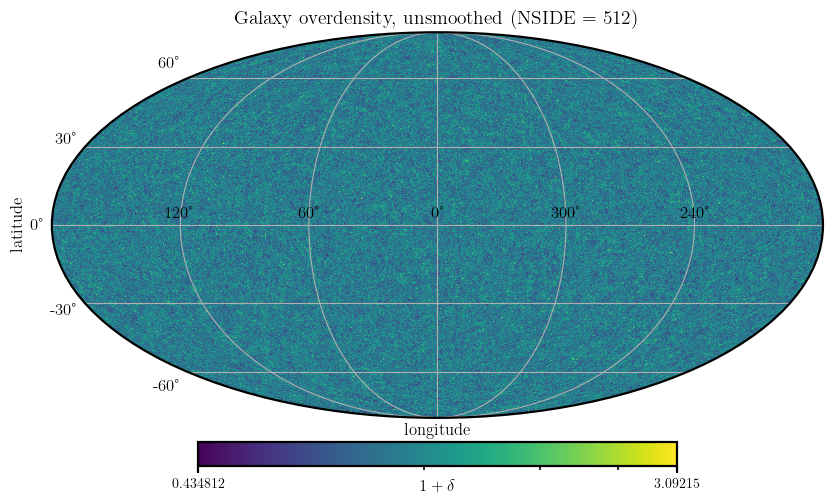

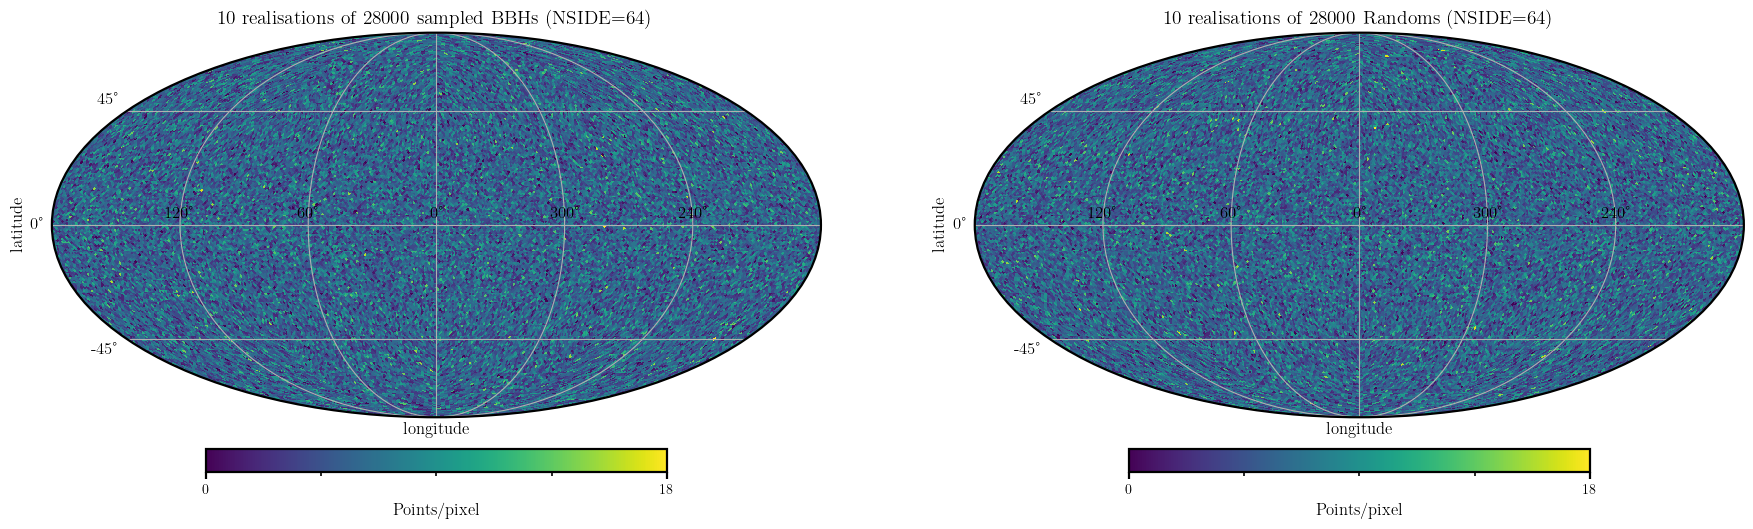

In [10]:
projview(
    1+delta_gal_masked,
    coord=["C"],
    graticule=True,
    graticule_labels=True,
    unit=r'$1+\delta$',
    xlabel="longitude",
    ylabel="latitude",
    cbar=True,
    cb_orientation="horizontal",
    latitude_grid_spacing=30,
    projection_type="mollweide",
    title=f"Galaxy overdensity, unsmoothed (NSIDE = {NSIDE})",
    norm="log", 
    flip="astro",
    min=1+delta_gal_masked[(delta_gal_masked!=hp.UNSEEN)&(1+delta_gal_masked>0)].min(),
    max=1+delta_gal_masked[delta_gal_masked!=hp.UNSEEN].max()
)

plt.show()
plt.close()

fig = plt.figure(figsize=(18, 7))
ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)

plt.axes(ax1)
projview(
    map_bbh,
    coord=["C"],
    graticule=True,
    graticule_labels=True,
    unit="\nPoints/pixel",
    xlabel="longitude",
    ylabel="latitude",
    cbar=True,
    cb_orientation="horizontal",
    latitude_grid_spacing=45,
    projection_type="mollweide",
    title=f"{N_realisations} realisations of {N_obj} sampled BBHs (NSIDE={64})",
    norm="linear", 
    flip="astro",
    # min=map_gal[mask!=hp.UNSEEN].min(),
    # max=map_gal[mask!=hp.UNSEEN].max(),
    hold=True,
    sub=121
)

plt.axes(ax2)
projview(
    map_1,
    coord=["C"],
    graticule=True,
    graticule_labels=True,
    unit="\nPoints/pixel",
    xlabel="longitude",
    ylabel="latitude",
    cbar=True,
    cb_orientation="horizontal",
    latitude_grid_spacing=45,
    projection_type="mollweide",
    title=f"{N_realisations} realisations of {N_obj} Randoms (NSIDE={64})",
    norm="linear", 
    flip="astro",
    # min=map_1[mask!=hp.UNSEEN].min(),
    # max=map_1[mask!=hp.UNSEEN].max(),
    hold=True,
    sub=122
)

plt.show()
plt.close()

In [15]:
#Saving

np.save(f'{fol_save}/Discrete_tracer_catalog_{r1_pos_masked_ds_arr.shape[0]}_realisations_of_{r1_pos_masked_ds_arr.shape[1]}_galaxies_randomly_sampled_from_the_sky.npy', r1_pos_masked_ds_arr)
np.save(f'{fol_save}/Discrete_tracer_catalog_{bbh_pos_masked_ds_arr.shape[0]}_realisations_of_{bbh_pos_masked_ds_arr.shape[1]}_galaxies_sampled_from_LSST_y1_forecast_Agora_lightcone_galaxy_overdensity_field_NSIDE_{NSIDE}_unmasked.npy', bbh_pos_masked_ds_arr)

## Loading datasets

In [7]:
fol_dataset = '/home/kaustubh/Projects/kNN-Samrajya/Datasets/kNN_2D_Ang'

NSIDE = 512
n_reals = 10
n_tracer = 28000

mask = np.ones(12*NSIDE**2)
mask[mask!=1] = hp.UNSEEN
delta_gal_masked = np.load(f'{fol_dataset}/LSST_y1_forecast_Agora_lightcone_galaxy_overdensity_field_NSIDE_{NSIDE}_unmasked.npy')
bbh_pos_masked_ds_arr = np.load(f'{fol_dataset}/Discrete_tracer_catalog_{n_reals}_realisations_of_{n_tracer}_galaxies_sampled_from_LSST_y1_forecast_Agora_lightcone_galaxy_overdensity_field_NSIDE_{NSIDE}_unmasked.npy')
r1_pos_masked_ds_arr = np.load(f'{fol_dataset}/Discrete_tracer_catalog_{n_reals}_realisations_of_{n_tracer}_galaxies_randomly_sampled_from_the_sky.npy')

## Query mask and query positions

In [8]:
# query_mask, query_pos = hf.create_query_2DA(NSIDE, mask, tolerance=0)

In [9]:
# np.save('query_mask_for_test.npy', query_mask)
# np.save('query_points_for_test.npy', query_pos)

In [11]:
query_mask = np.load('query_mask_for_test.npy')
query_pos = np.load('query_points_for_test.npy')

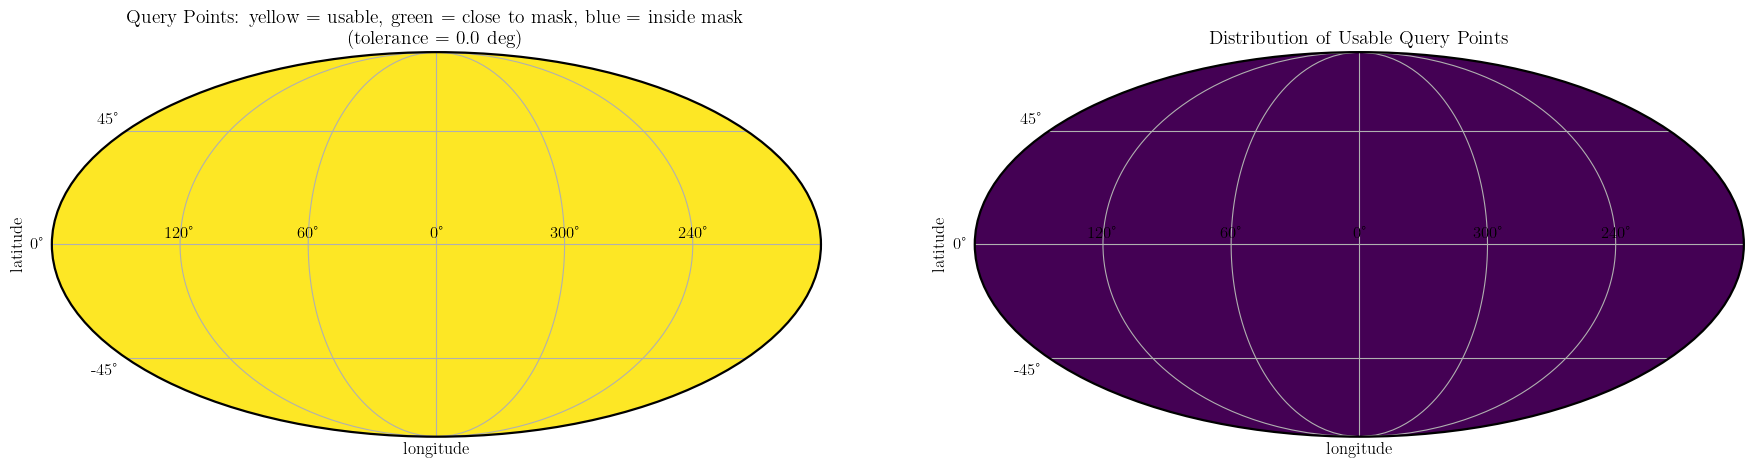

In [12]:
fig = plt.figure(figsize=(18, 7))
ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)

plt.axes(ax1)
projview(
    query_mask,
    coord=["C"],
    graticule=True,
    graticule_labels=True,
    unit="\nPoints/pixel",
    xlabel="longitude",
    ylabel="latitude",
    cbar=False,
    cb_orientation="horizontal",
    latitude_grid_spacing=45,
    projection_type="mollweide",
    title=f"Query Points: yellow = usable, green = close to mask, blue = inside mask \n(tolerance = {np.rad2deg(np.deg2rad(0))} deg)",
    norm="linear", 
    flip="astro",
    min = 0,
    max = 2,
    hold=True,
    sub=121
)

hpx_querymap = cat2hpx(np.rad2deg(query_pos)[:, 1], np.rad2deg(query_pos)[:, 0], nside=NSIDE, radec=False)
plt.axes(ax2)
projview(
    hpx_querymap,
    coord=["C"],
    graticule=True,
    graticule_labels=True,
    unit="\nPoints/pixel",
    xlabel="longitude",
    ylabel="latitude",
    cbar=False,
    cb_orientation="horizontal",
    latitude_grid_spacing=45,
    projection_type="mollweide",
    title="Distribution of Usable Query Points",
    norm="linear", 
    flip="astro",
    hold=True,
    sub=122
)

plt.show()
plt.close()

## Doing the Tests

### Determining the bins

/tmp/ipykernel_26056/2913211282.py:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sum+=(mean**i/np.math.factorial(i))*np.exp(-1*mean)


1NN 0.16 1.19
2NN 0.41 1.49
4NN 0.80 1.91

Angular distance bins for 1NN-CDF: 

 [0.14743297 0.18687831 0.23687717 0.30025309 0.3805851  0.48240975
 0.61147734 0.77507666 0.98244659 1.24529785]

Number of bins for 1NN-CDF:  10

Angular distance bins for 2NN-CDF: 

 [0.38811625 0.4531917  0.52917833 0.61790565 0.72150987 0.84248541
 0.98374492 1.1486894  1.34129012 1.5661842 ]

Number of bins for 2NN-CDF:  10

Angular distance bins for 4NN-CDF: 

 [0.76070084 0.84706703 0.94323881 1.05032944 1.16957862 1.30236676
 1.450231   1.614883   1.79822878 2.00239073]

Number of bins for 4NN-CDF:  10


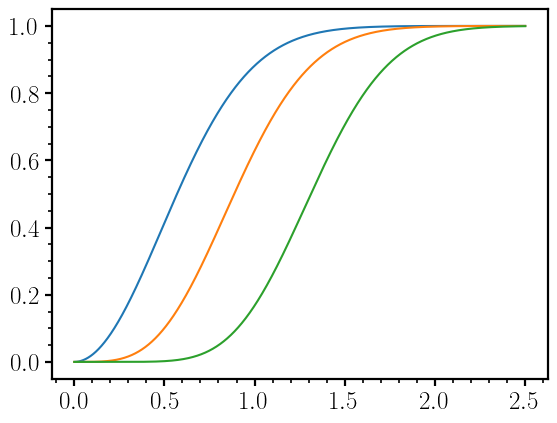

In [13]:
k_List = [1, 2, 4]
n_bar_red = (bbh_pos_masked_ds_arr.shape[1]/(4*np.pi))*(12*NSIDE**2/len(np.where(mask!=hp.UNSEEN)[0]))

bins = np.zeros((len(k_List), 10000))
for i, k in enumerate(k_List):
    bins[i] = np.deg2rad(np.geomspace(0.001, 2.5, 10000))

Theoretical_Uniform_CDFs_test = []
for i, k in enumerate(k_List):
    Theoretical_Uniform_CDFs_test.append(PoissonUniformCDFs(2*np.pi*(1-np.cos(bins[i])), n_bar_red, k))

for i, k in enumerate(k_List):
    plt.plot(np.rad2deg(bins[i]), Theoretical_Uniform_CDFs_test[i])

low_bin = np.zeros(len(k_List)).astype(int)
high_bin = np.zeros(len(k_List)).astype(int)
for i, k in enumerate(k_List):
    low_bin[i] = np.searchsorted(Theoretical_Uniform_CDFs_test[i], 0.05)
    high_bin[i] = np.searchsorted(Theoretical_Uniform_CDFs_test[i], 0.95)
    print(f'{k}NN', '{:.2f}'.format(np.rad2deg(bins[i][low_bin[i]])), '{:.2f}'.format(np.rad2deg(bins[i][high_bin[i]])))

sel_bins = np.zeros((len(k_List), 10))
for i, k in enumerate(k_List):
    sel_bins[i] = np.geomspace(bins[i][low_bin[i]]*0.95, bins[i][high_bin[i]]*1.05, 10)

for i, k in enumerate(k_List):
    print(f'\nAngular distance bins for {k}NN-CDF: \n\n', np.rad2deg(sel_bins[i]))
    print(f'\nNumber of bins for {k}NN-CDF: ', len(sel_bins[i]))

### Computing the theoretical CDFs for Poisson data

/tmp/ipykernel_26056/2913211282.py:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sum+=(mean**i/np.math.factorial(i))*np.exp(-1*mean)


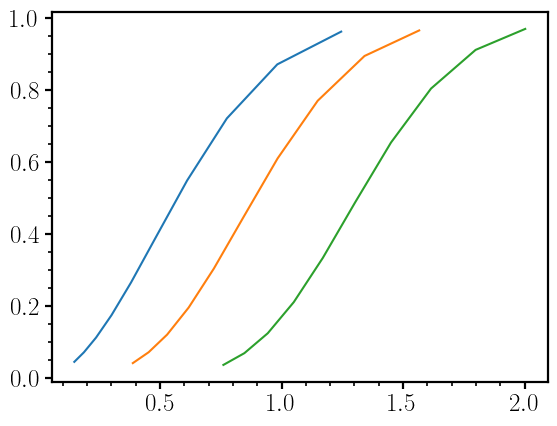

In [14]:
th_uni_arr = np.zeros((len(k_List), sel_bins.shape[1]))
for i, k in enumerate(k_List):
    th_uni_arr[i] = PoissonUniformCDFs(2*np.pi*(1-np.cos(sel_bins[i])), n_bar_red, k)

for i, k in enumerate(k_List):
    plt.plot(np.rad2deg(sel_bins[i]), th_uni_arr[i])

### testing kNN_2D_Ang.TracerAuto2DA

In [12]:
random_kNN_results = kNN_2D_Ang.TracerAuto2DA(k_List, sel_bins, query_pos, r1_pos_masked_ds_arr[0], ReturnNNdist=False, Verbose=True)

Checking inputs ...
	done.

building the tree ...
	done; time taken: 5.16e-02 s.

computing the tracer NN distances ...
	done; time taken: 8.89e+01 s.

computing the tracer auto-CDFs P_{>=k} ...
	done; time taken: 3.31e+00 s.

total time taken: 9.24e+01 s.


In [13]:
random_autoCDFs = random_kNN_results

Text(0, 0.5, '\\% residual between\nmeasuremed and theoretical value')

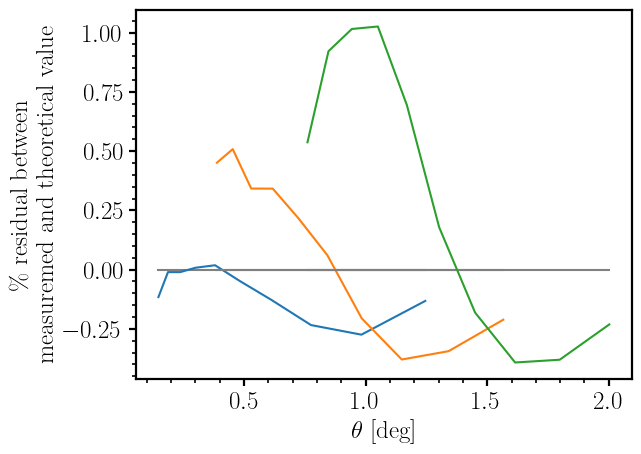

In [16]:
for i, k in enumerate(k_List):
    plt.plot(np.rad2deg(sel_bins[i]), 100*(th_uni_arr[i]/th_uni_arr[i] - 1), c='grey')
    plt.plot(np.rad2deg(sel_bins[i]), 100*(random_autoCDFs[i]/th_uni_arr[i] - 1), c=DefaultColorCycle[i])
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel('\% residual between\nmeasuremed and theoretical value')

### testing kNN_2D_Ang.TracerFieldCross2DA

In [15]:
delta_threshold = 75.0

In [16]:
randomxgalaxy_kNN_results = kNN_2D_Ang.TracerFieldCross2DA(k_List, sel_bins, query_pos, r1_pos_masked_ds_arr[0], delta_gal_masked, query_mask, delta_threshold, ReturnSmoothedDict=False, Verbose=True)

Checking inputs ...
	done.

initiating step 1 (NN measurements for the discrete tracer set)...

	building the tree ...
		done; time taken: 2.99e-02 s.

	computing the tracer NN distances ...
		done; time taken: 5.24e+01 s.

	computing the tracer auto-CDFs P_{>=k} ...
		done; time taken: 1.97e+00 s.

time taken for step 1: 5.44e+01 s.

initiating step 2 (smoothing the continuous field at the given angular distance scales)...
	done; time taken for step 2: 9.45e+01 s.

initiating step 3 (computing the tracer-field cross-correlation)...

	Computing P_(>dt) and P_(>=k, >dt) for k = 1 ...

	Computing P_(>dt) and P_(>=k, >dt) for k = 2 ...

	Computing P_(>dt) and P_(>=k, >dt) for k = 4 ...
	done; time taken for step 3: 1.63e+00 s.

total time taken: 1.51e+02 s.


In [17]:
random_autoCDFs = randomxgalaxy_kNN_results[0]
random_pdt = randomxgalaxy_kNN_results[1]
random_jointCDFs = randomxgalaxy_kNN_results[2]

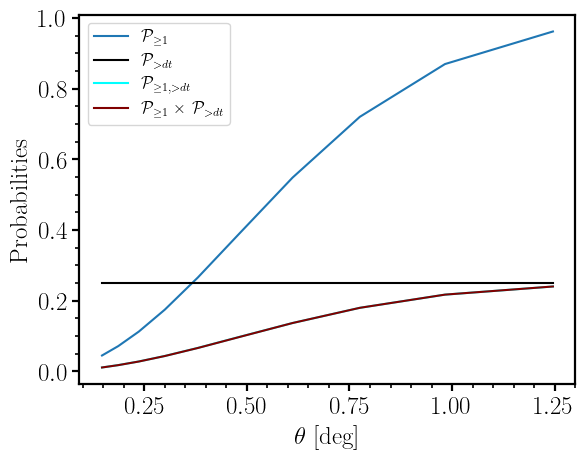

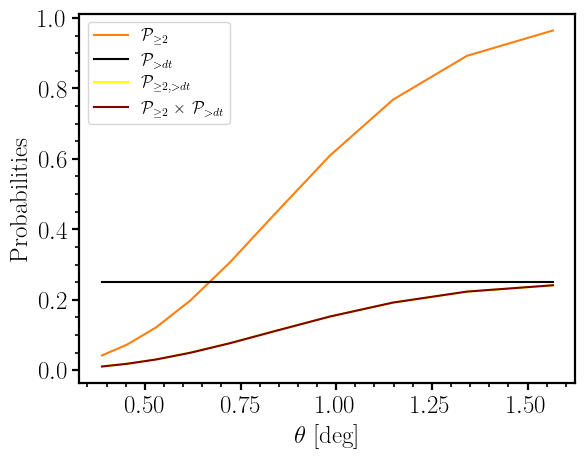

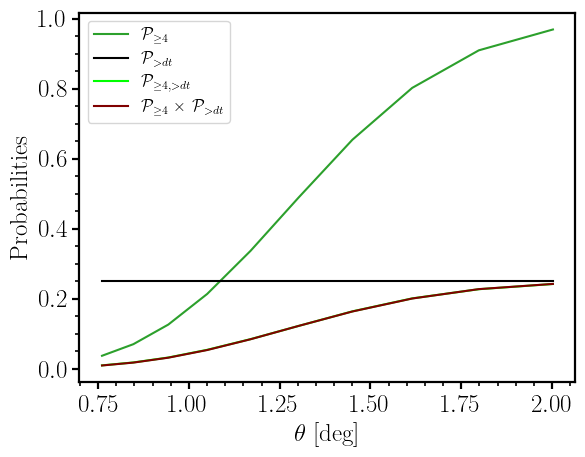

In [21]:
for i, k in enumerate(k_List):
    plt.plot(np.rad2deg(sel_bins[i]), random_autoCDFs[i], c=DefaultColorCycle[i], label='$\\mathcal{{P}}_{{\\geq {:.0f}}}$'.format(k))
    plt.plot(np.rad2deg(sel_bins[i]), random_pdt[i], c='k', label='$\\mathcal{{P}}_{{>dt}}$')
    plt.plot(np.rad2deg(sel_bins[i]), random_jointCDFs[i], c=BrightColors[i], label='$\\mathcal{{P}}_{{\\geq {:.0f}, >dt}}$'.format(k))
    plt.plot(np.rad2deg(sel_bins[i]), random_autoCDFs[i]*random_pdt[i], c='maroon', label='$\\mathcal{{P}}_{{\\geq {:.0f}}}$ $\\times$ $\\mathcal{{P}}_{{>dt}}$'.format(k))
    plt.xlabel(r'$\theta$ [deg]')
    plt.ylabel('Probabilities')
    plt.legend(fontsize=12)
    plt.show()
    plt.close()

In [23]:
dataxgalaxy_kNN_results = kNN_2D_Ang.TracerFieldCross2DA(k_List, sel_bins, query_pos, bbh_pos_masked_ds_arr[0], delta_gal_masked, query_mask, delta_threshold, ReturnSmoothedDict=True, Verbose=True)

Checking inputs ...
	done.

initiating step 1 (NN measurements for the discrete tracer set)...

	building the tree ...
		done; time taken: 3.24e-02 s.

	computing the tracer NN distances ...
		done; time taken: 5.35e+01 s.

	computing the tracer auto-CDFs P_{>=k} ...
		done; time taken: 1.90e+00 s.

time taken for step 1: 5.54e+01 s.

initiating step 2 (smoothing the continuous field at the given angular distance scales)...
	done; time taken for step 2: 9.78e+01 s.

initiating step 3 (computing the tracer-field cross-correlation)...

	Computing P_(>dt) and P_(>=k, >dt) for k = 1 ...

	Computing P_(>dt) and P_(>=k, >dt) for k = 2 ...

	Computing P_(>dt) and P_(>=k, >dt) for k = 4 ...
	done; time taken for step 3: 1.54e+00 s.

total time taken: 1.55e+02 s.


In [24]:
data_autoCDFs = dataxgalaxy_kNN_results[0]
data_pdt = dataxgalaxy_kNN_results[1]
data_jointCDFs = dataxgalaxy_kNN_results[2]
smootheddict = dataxgalaxy_kNN_results[3]

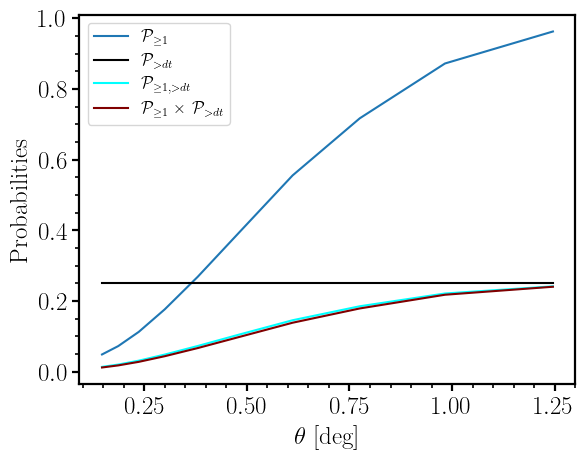

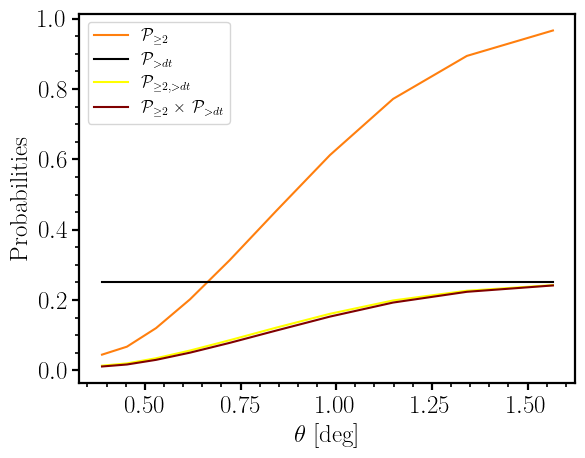

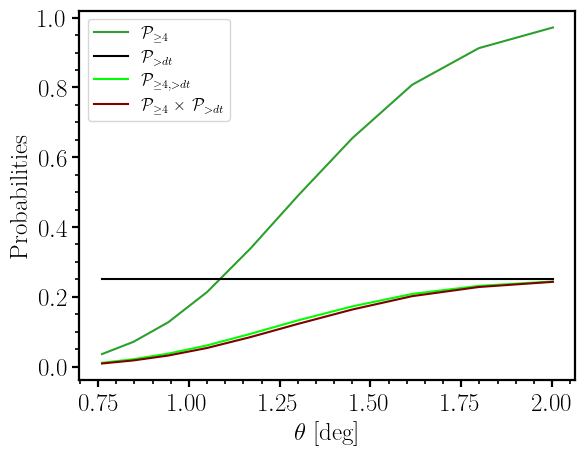

In [25]:
for i, k in enumerate(k_List):
    plt.plot(np.rad2deg(sel_bins[i]), data_autoCDFs[i], c=DefaultColorCycle[i], label='$\\mathcal{{P}}_{{\\geq {:.0f}}}$'.format(k))
    plt.plot(np.rad2deg(sel_bins[i]), data_pdt[i], c='k', label='$\\mathcal{{P}}_{{>dt}}$')
    plt.plot(np.rad2deg(sel_bins[i]), data_jointCDFs[i], c=BrightColors[i], label='$\\mathcal{{P}}_{{\\geq {:.0f}, >dt}}$'.format(k))
    plt.plot(np.rad2deg(sel_bins[i]), data_autoCDFs[i]*data_pdt[i], c='maroon', label='$\\mathcal{{P}}_{{\\geq {:.0f}}}$ $\\times$ $\\mathcal{{P}}_{{>dt}}$'.format(k))
    plt.xlabel(r'$\theta$ [deg]')
    plt.ylabel('Probabilities')
    plt.legend(fontsize=12)
    plt.show()
    plt.close()

In [30]:
randoms_psi = hf.kNN_excess_cross_corr(random_autoCDFs, random_pdt, random_jointCDFs, k1_k2_list=None)
data_psi = hf.kNN_excess_cross_corr(data_autoCDFs, data_pdt, data_jointCDFs, k1_k2_list=None)

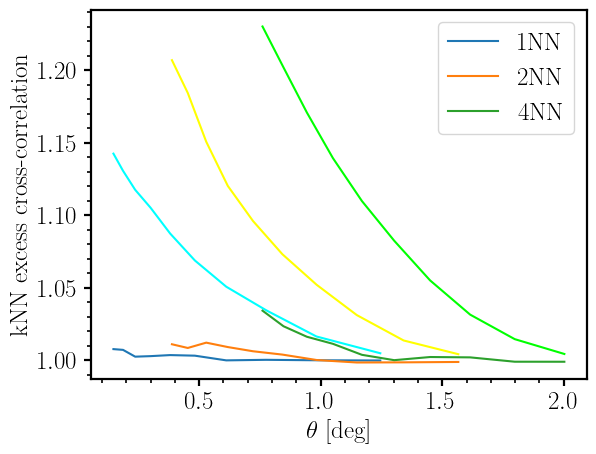

In [34]:
for i, k in enumerate(k_List):
    plt.plot(np.rad2deg(sel_bins[i]), randoms_psi[i], c=DefaultColorCycle[i], label=f'{k}NN')
    plt.plot(np.rad2deg(sel_bins[i]), data_psi[i], c=BrightColors[i])
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel('kNN excess cross-correlation')
plt.legend()